In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('input_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106 entries, 0 to 10105
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Original      10106 non-null  object
 1   PrivacyRatio  10106 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.0+ KB


In [2]:
df_3 = df.copy()
df_4 = df.copy()
from collections import Counter
for i, row in df_3.iterrows():
    if row['PrivacyRatio'] >= 3:
        df_3.loc[i, 'PrivacyRatio'] = 1
    else:
        df_3.loc[i, 'PrivacyRatio'] = 0
# Counter(df['label'])
Counter(df_3['PrivacyRatio'])

Counter({1: 5536, 0: 4570})

In [3]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
def token(text):
    vocab = {} # 파이썬의 dictionary 자료형
    sentences = []
    stop_words = set(stopwords.words('english'))
    # text = sent_tokenize(text)

    for i in text:
        sentence = word_tokenize(i) # 단어 토큰화를 수행합니다.
        result = []

        for word in sentence: 
            word = word.lower() # 모든 단어를 소문자화하여 단어의 개수를 줄입니다.
            if word not in stop_words: # 단어 토큰화 된 결과에 대해서 불용어를 제거합니다.
                if len(word) > 2: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
                    result.append(word)
                    if word not in vocab:
                        vocab[word] = 0 
                    vocab[word] += 1
        sentences.append(result) 
    tokenizer.fit_on_texts(sentences)
    return tokenizer.texts_to_sequences(sentences)
    # t = tokenizer.texts_to_sequences(sentences)
    # return np.concatenate(t).tolist()

In [4]:
data = df_3['Original'].tolist()
target = df_3['PrivacyRatio'].tolist()
data = np.array(token(data))
target = np.array(target)
# data

<ipython-input-4-f86f325f911e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(token(data))


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42, test_size=0.5, stratify=df_3.PrivacyRatio.values)
# X_train.shape, X_test.shape

In [6]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 5053
테스트용 리뷰 개수 : 5053
카테고리 : 2


In [7]:
X_train[2]

[986, 768, 8, 1, 614, 9, 330, 67, 7, 179, 1248, 351, 141, 986, 62, 76, 9, 330]

리뷰의 최대 길이 : 58
리뷰의 평균 길이 : 14.148228774985157


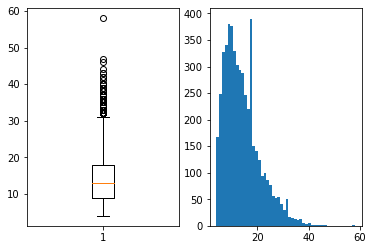

In [8]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [9]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1]
 [2285 2768]]


In [10]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [11]:
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [12]:
vocab_size = 10000

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)